# Series de tiempo en finanzas 2023

#**GRUPO 1**
 - Esequiel Armeria
 - Guillermo Laion
 - Ruben Mendoza
 - Sofia Risso

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import os
import itertools

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from PIL import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

 ## Problema 1:

- Objetivo de este problema: Estudiar la demanda mensual de energia electrica en Victoria. Realice gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb** realice

- Gráfico de radar

- Gráfico de barra circular

- Gráfico de ploteo radial

- Genere un única imagen uniendo los gráficos anuales para cada caso.

## Datos (extraído del notebook de clase "Exploracion demanda energia electrica")



Los datos empleados en este documento obtuvieron a partir del paquete de R [tsibbledata]("https://tsibbledata.tidyverts.org/"). El set de datos contiene 5 columnas y 52608 registros completos. La información de cada columna es:

+ Time: fecha y hora del registro.

+ Date: fecha del registro

+ Demand: demanda de electricidad MW.

+ Temperature: temperatura en Melbourne, capital del estado de Victoria.

+ Holiday: indicador si el día es festivo (vacaciones).

### Descarga de datos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vic_elec.csv to vic_elec.csv


In [ ]:
datos = pd.read_csv('vic_elec.csv', sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [ ]:
datos.head(10)

Time       Demand  Temperature        Date  Holiday
0  2011-12-31T13:00:00Z  4382.825174        21.40  2012-01-01     True
1  2011-12-31T13:30:00Z  4263.365526        21.05  2012-01-01     True
2  2011-12-31T14:00:00Z  4048.966046        20.70  2012-01-01     True
3  2011-12-31T14:30:00Z  3877.563330        20.55  2012-01-01     True
4  2011-12-31T15:00:00Z  4036.229746        20.40  2012-01-01     True
5  2011-12-31T15:30:00Z  3865.597244        20.25  2012-01-01     True
6  2011-12-31T16:00:00Z  3694.097664        20.10  2012-01-01     True
7  2011-12-31T16:30:00Z  3561.623686        19.60  2012-01-01     True
8  2011-12-31T17:00:00Z  3433.035352        19.10  2012-01-01     True
9  2011-12-31T17:30:00Z  3359.468000        18.95  2012-01-01     True

### Manejo del indice temporal

Al importar un conjunto de datos indexados en tiempo, es importante estudiar qué información del muestreo de los datos contiene el dataset. Por ello, suele haber una variable llamada tiempo o fechas o similar, que hace referencia a ese muestreo. Pueden existir datos faltantes o duplicados, lo cual ocurre cuando se retrasa o se adelanta la hora en alguna época del año.  

En este dataset, la columna *Time* se ha almacenado como `string`. Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **pandas**, se establece como índice. Además, dado que los datos se han registrado cada 30 minutos, se indica la frecuencia ('30min').

In [ ]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos

Demand  Temperature        Date  Holiday
Time                                                              
2011-12-31 13:00:00  4382.825174        21.40  2012-01-01     True
2011-12-31 13:30:00  4263.365526        21.05  2012-01-01     True
2011-12-31 14:00:00  4048.966046        20.70  2012-01-01     True
2011-12-31 14:30:00  3877.563330        20.55  2012-01-01     True
2011-12-31 15:00:00  4036.229746        20.40  2012-01-01     True
...                          ...          ...         ...      ...
2014-12-31 10:30:00  3873.448714        19.00  2014-12-31    False
2014-12-31 11:00:00  3791.637322        18.50  2014-12-31    False
2014-12-31 11:30:00  3724.835666        17.70  2014-12-31    False
2014-12-31 12:00:00  3761.886854        17.30  2014-12-31    False
2014-12-31 12:30:00  3809.414586        17.10  2014-12-31    False

[52608 rows x 4 columns]

Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa, esto es, analizar si no existen registros temporales faltantes o duplicados.

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)
).all()

True

### Manejo del muestreo

En muchos casos, los datos tienen una frecuencia mayor a la que se quiere estudiar, o en la frecuencia de muestreo dada, la variabilidad es muy alta por lo cual un suavizado mediante acumulacion de informacion es aconsejable.

En nuestro caso, los datos se encuentran en intervalos de 30 minutos, y se desea trabajar con la demanda eléctrica a nivel horario, por lo que se tienen que promediar los datos en el intervalo deseado para generar un único valor. Este tipo de transformación es muy sencilla si se combina el índice de tipo temporal de pandas y su método `resample()`.

Es muy importante utilizar correctamente los argumentos `closed='left'` y `label='right'` para no introducir en el entrenamiento información a futuro ([*leakage*](https://en.wikipedia.org/wiki/Leakage_(machine_learning))). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

In [ ]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al acumular. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

Demand  Temperature  Holiday
Time                                                  
2011-12-31 14:00:00  4323.095350       21.225      1.0
2011-12-31 15:00:00  3963.264688       20.625      1.0
2011-12-31 16:00:00  3950.913495       20.325      1.0
2011-12-31 17:00:00  3627.860675       19.850      1.0
2011-12-31 18:00:00  3396.251676       19.025      1.0
...                          ...          ...      ...
2014-12-31 09:00:00  4069.625550       21.600      0.0
2014-12-31 10:00:00  3909.230704       20.300      0.0
2014-12-31 11:00:00  3900.600901       19.650      0.0
2014-12-31 12:00:00  3758.236494       18.100      0.0
2014-12-31 13:00:00  3785.650720       17.200      0.0

[26304 rows x 3 columns]

In [ ]:
# Crea las nuevas columnas
datos['Year'] = datos.index.year
datos['Month'] = datos.index.month
datos['Year_Month'] = datos.index.to_period('M')

# Muestra el DataFrame resultante
datos

Demand  Temperature  Holiday  Year  Month Year_Month
Time                                                                          
2011-12-31 14:00:00  4323.095350       21.225      1.0  2011     12    2011-12
2011-12-31 15:00:00  3963.264688       20.625      1.0  2011     12    2011-12
2011-12-31 16:00:00  3950.913495       20.325      1.0  2011     12    2011-12
2011-12-31 17:00:00  3627.860675       19.850      1.0  2011     12    2011-12
2011-12-31 18:00:00  3396.251676       19.025      1.0  2011     12    2011-12
...                          ...          ...      ...   ...    ...        ...
2014-12-31 09:00:00  4069.625550       21.600      0.0  2014     12    2014-12
2014-12-31 10:00:00  3909.230704       20.300      0.0  2014     12    2014-12
2014-12-31 11:00:00  3900.600901       19.650      0.0  2014     12    2014-12
2014-12-31 12:00:00  3758.236494       18.100      0.0  2014     12    2014-12
2014-12-31 13:00:00  3785.650720       17.200      0.0  2014     12    2014-12

[26304 rows x 6 columns]

In [ ]:
datos[datos['Year'] == 2011]

Demand  Temperature  Holiday  Year  Month Year_Month
Time                                                                          
2011-12-31 14:00:00  4323.095350       21.225      1.0  2011     12    2011-12
2011-12-31 15:00:00  3963.264688       20.625      1.0  2011     12    2011-12
2011-12-31 16:00:00  3950.913495       20.325      1.0  2011     12    2011-12
2011-12-31 17:00:00  3627.860675       19.850      1.0  2011     12    2011-12
2011-12-31 18:00:00  3396.251676       19.025      1.0  2011     12    2011-12
2011-12-31 19:00:00  3317.992230       18.725      1.0  2011     12    2011-12
2011-12-31 20:00:00  3274.052232       18.675      1.0  2011     12    2011-12
2011-12-31 21:00:00  3432.421122       19.650      1.0  2011     12    2011-12
2011-12-31 22:00:00  3650.038153       21.775      1.0  2011     12    2011-12
2011-12-31 23:00:00  4000.933475       24.650      1.0  2011     12    2011-12

El set de datos empieza el *2011-12-31 14:00:00* y termina el *2014-12-31 13:00:00*. Se descartan los primeros 10 y los últimos 13 registros para que empiece el *2012-01-01 00:00:00* y termine el *2014-12-30 23:00:00*.

In [ ]:
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']

## Gráfico de radar interactivo

Este tipo de gráfico se puede construir utilizando la biblioteca de gráficos interactivos de Plotly y estableciendo el eje angular en el diagrama de dispersión. Cada mes se seleccionará como una variable en el círculo. Por ejemplo, en este caso, crearemos un gráfico de radar que compare demanda mensual de energia electrica en Victoria para los meses comprendidos entre 2012 y 2014.
Este tipo de gráfico permite realizar comparaciones entre las diferentes categorías (años).


In [ ]:
# Diccionario para mapear números de mes a nombres de mes
month_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Colores para cada año
colors = {'2012': 'green', '2013': 'red', '2014': 'black'}

def polar_plot(data, column_name):
    # Crea el gráfico polar
    fig = go.Figure()

    # Itera sobre cada año y su color correspondiente
    for year, color in colors.items():
        # Filtra el DataFrame para el año actual
        data_subset = data[data['Year'] == int(year)].groupby('Month')[column_name].sum().reset_index()

        # Agrega un trazado al gráfico polar para el año actual
        fig.add_trace(go.Scatterpolar(
            r=data_subset[column_name],
            theta=data_subset['Month'].map(month_dict),
            name=year,
            marker=dict(color=color)
        ))

    # Actualiza el diseño del gráfico polar
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 4e6])),
        showlegend=True,
        width=800,
        height=800,
        font=dict(size=14),
        title=f'{column_name} Total por Mes'
    )


    fig.show()

polar_plot(datos,'Demand')

A partir de este gráfico es posible observar que en general, la demanda energética presentó un comportamiento similar durante el periodo estudiado, y que las mayores diferencias se encontraron entre los meses de febrero y junio.

## Gráfico de barras circular o gráfica de pista de carrera (Circular Bar Plot)

Como su nombre lo indica, constituyen gráficos de barra en un círculo que uutilizan coordenadas cartesianas. Posee la ventaja de ofrecer una visualización llamativa de los datos, sin embargo, a diferencia del gráfico anterior, la representación dificulta poder realizar comparaciones entre categorías diferentes. En el caso en cuestión esto se traduciría en una dificultad para comparar la demanda energética de un mes determinado para diferentes años (2012-2014).


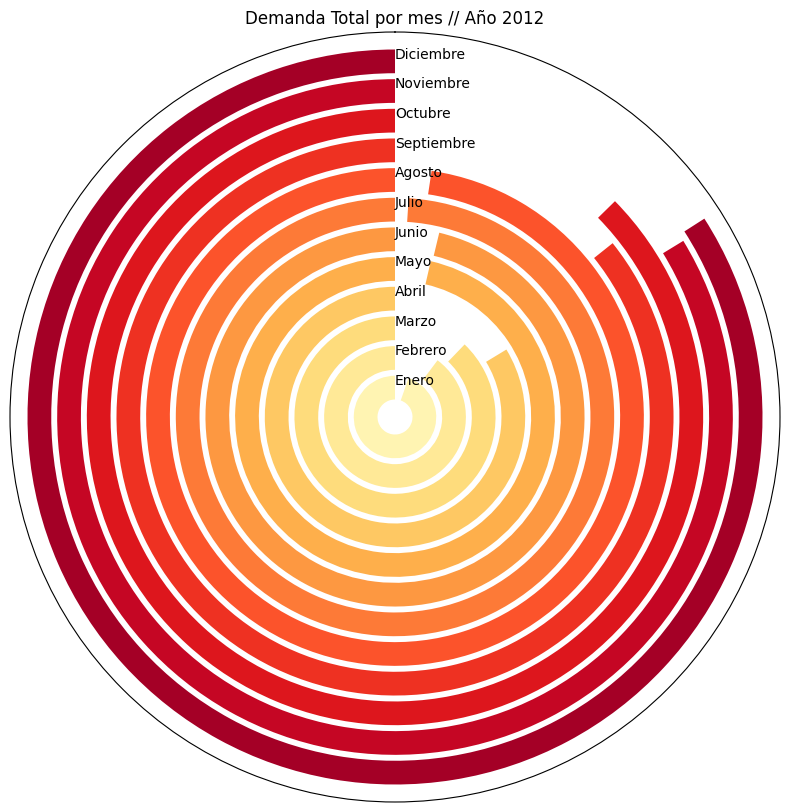

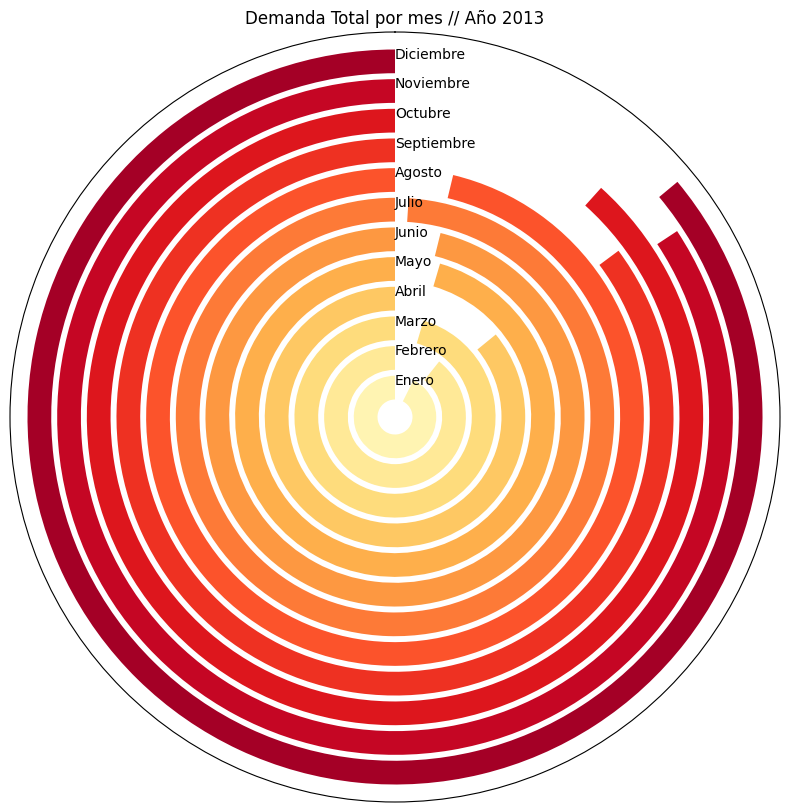

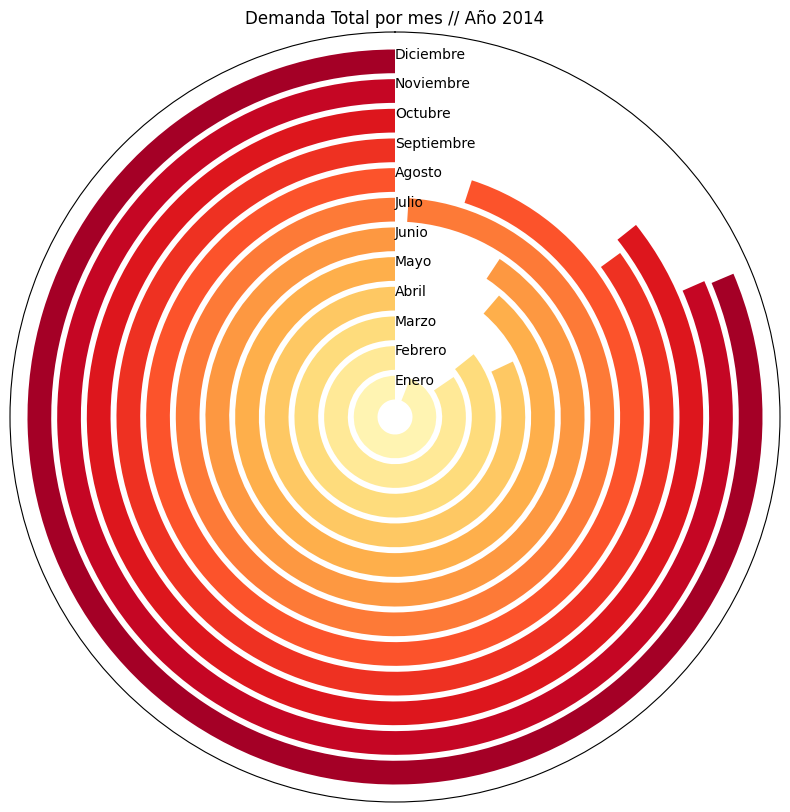

In [ ]:
# Genera una paleta de colores para los trazados
pal = list(sns.color_palette(palette='YlOrRd', n_colors=len(datos['Month'].unique())).as_hex())

def circular_bar(input_df, column_name):
    # Itera sobre cada año
    for year, color in zip(input_df['Year'].unique(), pal):
        # Filtra el DataFrame para el año actual
        year_data = input_df[input_df['Year'] == year].groupby('Month')[column_name].sum().reset_index()

        # Establece el tamaño de los gráficos fuera del bucle
        plt.gcf().set_size_inches(10, 10)
        ax = plt.subplot(projection='polar')
        year_data.reset_index(inplace=True, drop=True)

        # Crea barras circulares para cada mes
        for i, (month, value) in enumerate(zip(year_data['Month'], year_data[column_name])):
            ax.barh(i, value*2*np.pi/year_data[column_name].max()/1.01, label=month_dict[month], color=pal[i])

        ax.set_theta_zero_location('N')
        ax.set_theta_direction(1)
        ax.set_rlabel_position(0)
        ax.set_thetagrids([], labels=[])
        ax.set_rgrids(range(len(year_data)), labels=[month_dict[m] for m in year_data['Month']])

        ax.grid(False)  # Elimina el grid de las barras
        plt.title(f"Demanda Total por mes // Año {year}")
        plt.show()

# Llama a la función con tu DataFrame y columna de interés
circular_bar(datos, 'Demand')


##Gráfico de ploteo radial

Este tipo de gráfico se compone de barras y posee las mismas ventajas y desventajas expuestas para el gráfico de barras circular. La diferencia está en que los gráficos de ploteo radial utilizan coordenadas polares en lugar de coordenadas cartesianas. Puede ser utilizado en infografías.



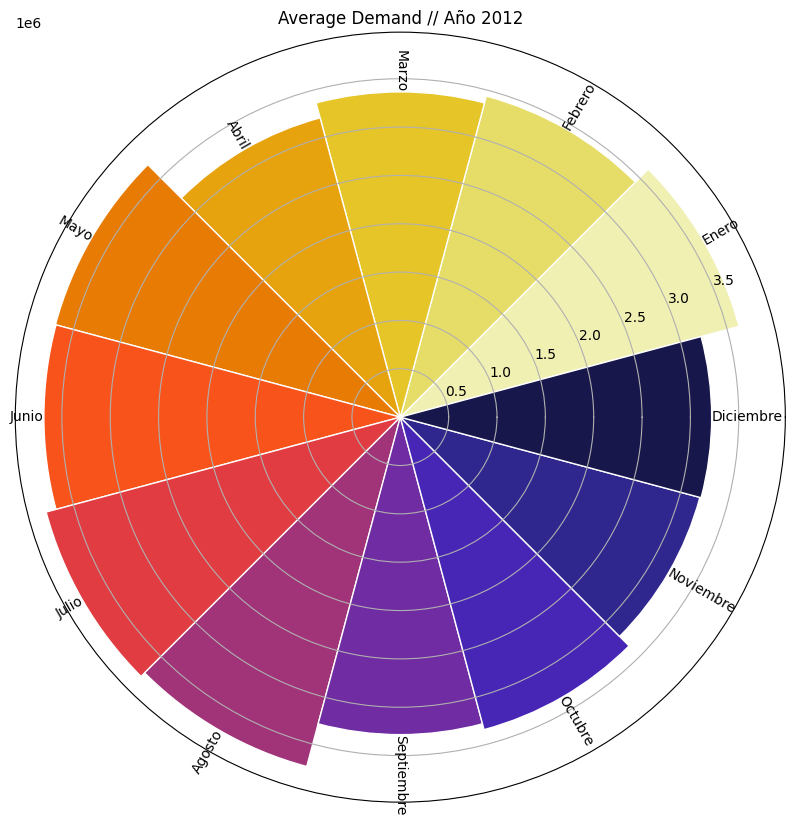

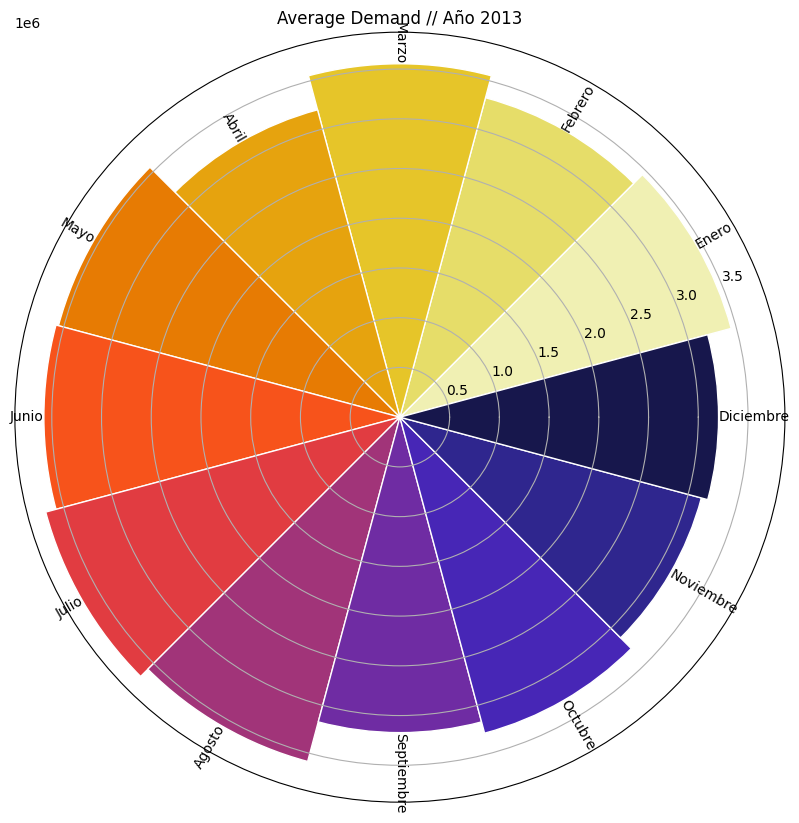

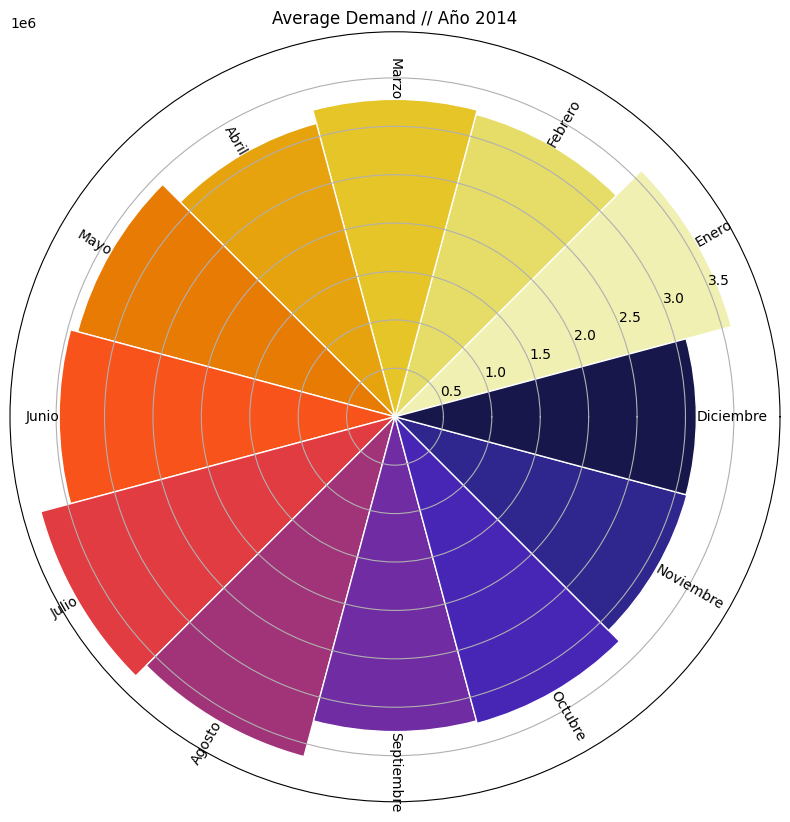

In [ ]:
# Set color palette, lower, and max values
pal = list(sns.color_palette(palette='CMRmap_r', n_colors=len(datos['Month'].unique())).as_hex())
lowerLimit = 0

def radial_plot(input_df, column_name):
    # Itera sobre cada año
    for year in input_df['Year'].unique():
        # Filtra el DataFrame para el año actual
        year_data = input_df[input_df['Year'] == year].groupby('Month')[column_name].sum().reset_index()
        year_data.reset_index(inplace=True, drop=True)

        plt.figure(figsize=(10, 10))
        ax = plt.subplot(111, polar=True)
        plt.axis()

        heights = year_data[column_name]
        width = 2 * np.pi / len(year_data.index)

        indexes = list(range(1, len(year_data.index) + 1))
        angles = [element * width for element in indexes]

        bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit, linewidth=1, edgecolor="white", color=pal)

        labelPadding = 2

        for bar, angle, height, label in zip(bars, angles, heights, year_data['Month']):
            rotation = np.rad2deg(angle)
            alignment = ""

            if angle >= np.pi / 2 and angle < 3 * np.pi / 2:
                alignment = "right"
                rotation = rotation + 180
            else:
                alignment = "left"

            ax.text(x=angle, y=lowerLimit + bar.get_height() + labelPadding,
                    s=month_dict[label], ha=alignment, va='center', rotation=rotation, rotation_mode="anchor")

        ax.set_thetagrids([], labels=[])
        plt.title(f"Average {column_name} // Año {year}")

        plt.show()

# Llama a la función con tu DataFrame y columna de interés
radial_plot(datos, 'Demand')


A continuación se muestra una visualización de todos los tipos de gráficos juntos.

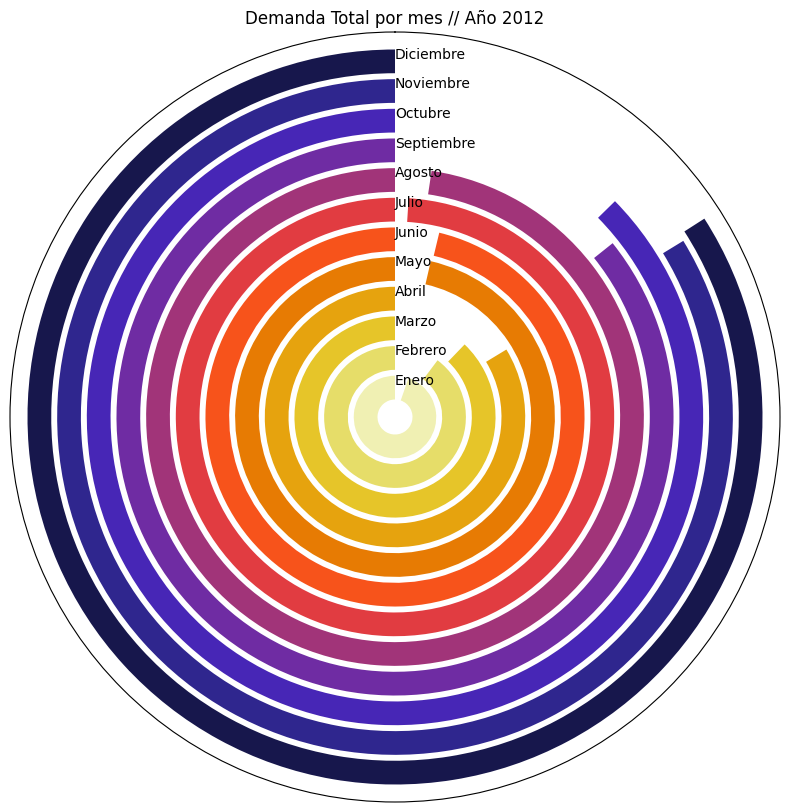

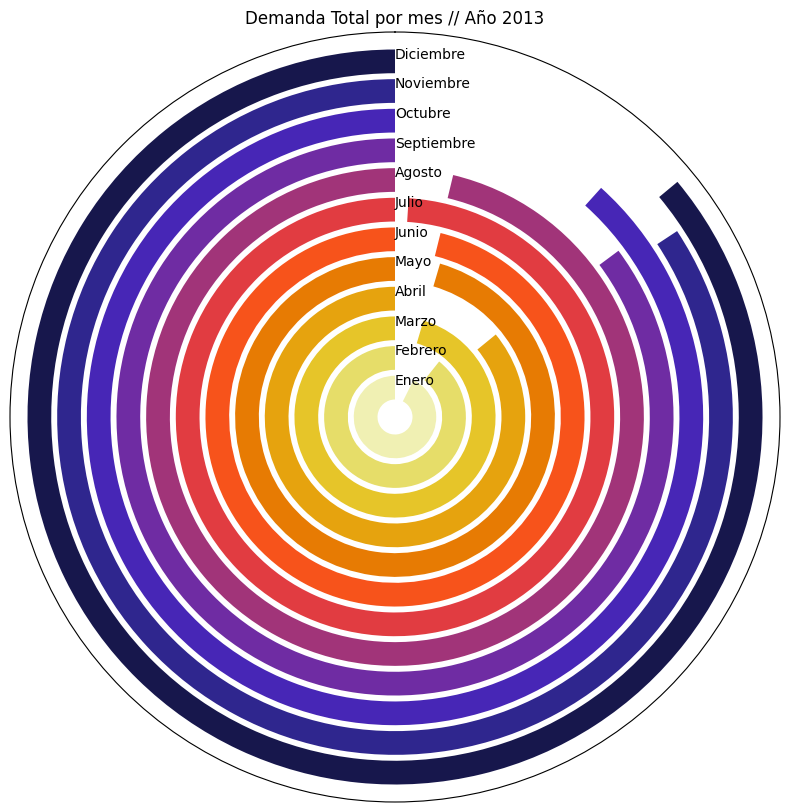

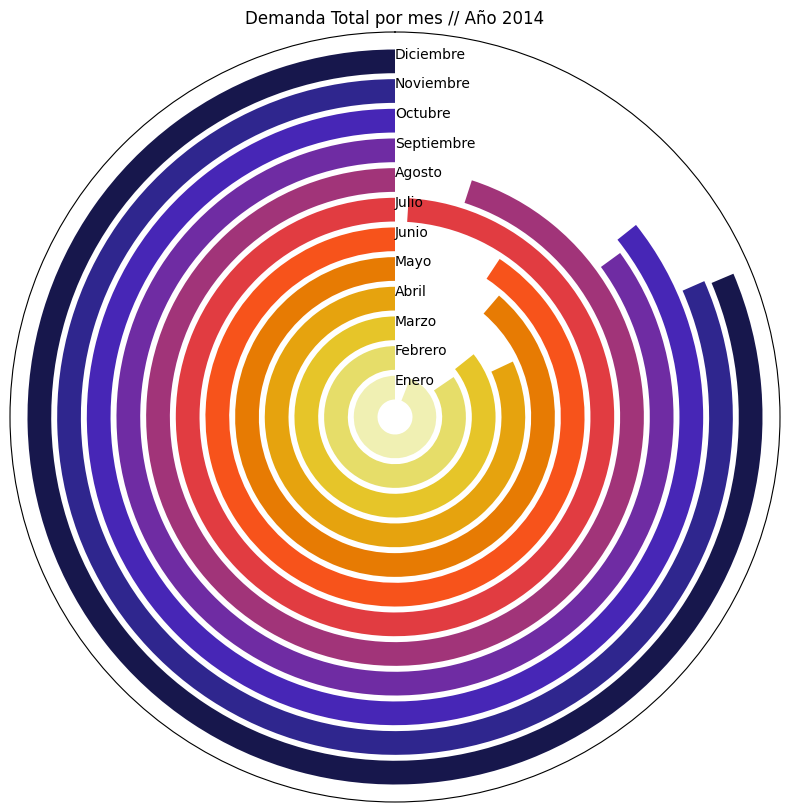

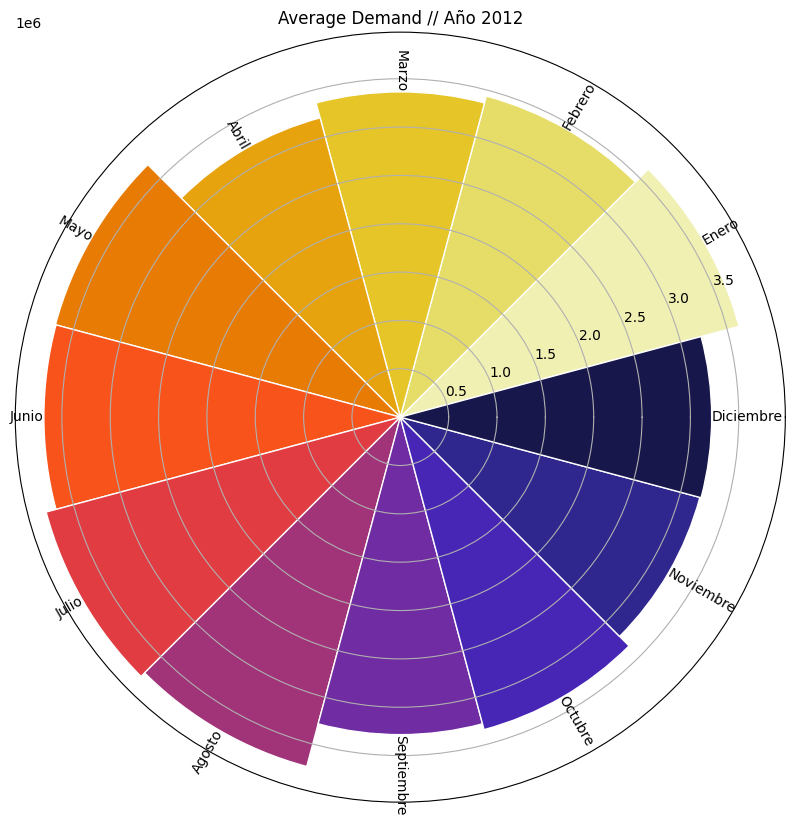

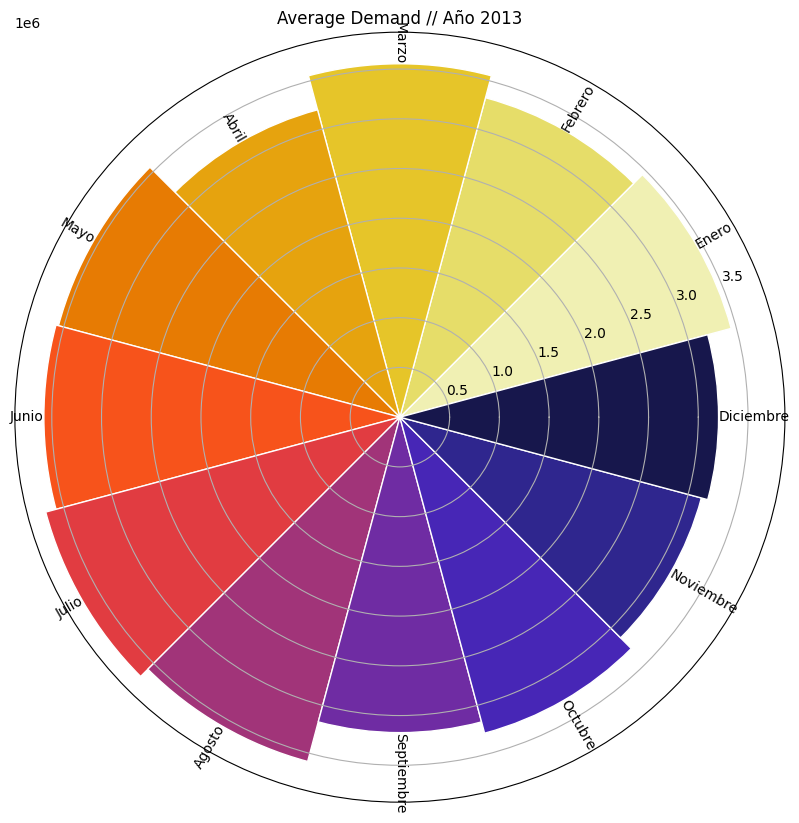

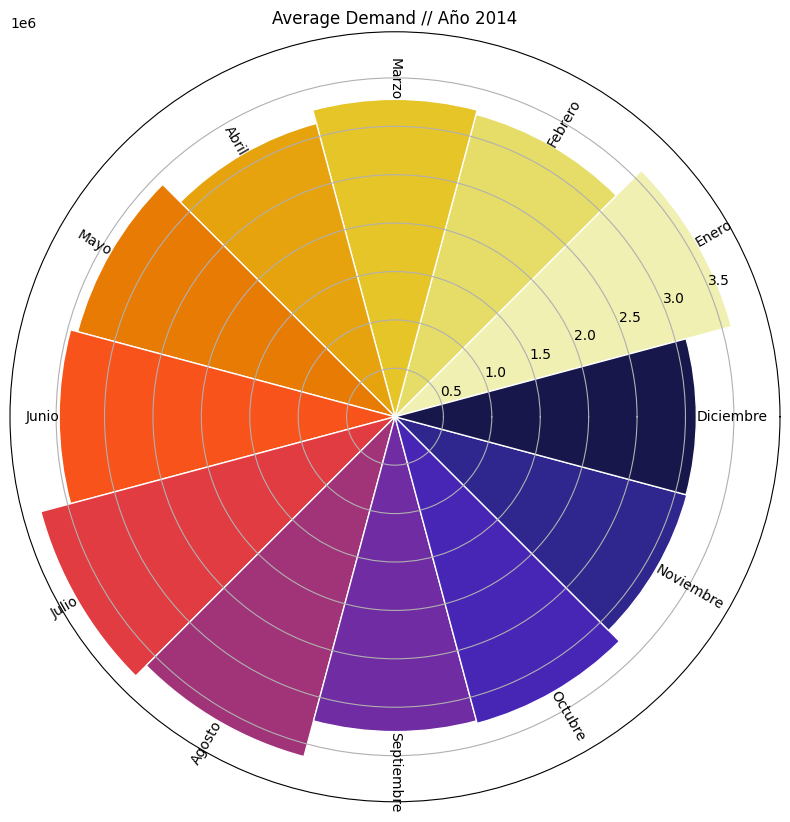

In [ ]:
def get_collage(cols_n, rows_n, width, height, function_list, save_name):
    c_width = width // cols_n
    c_height = height // rows_n
    size = c_width, c_height
    new_im = Image.new('RGB', (width, height))
    ims = []

    # Lista para almacenar las salidas de las funciones
    function_outputs = []

    i, x, y = 0, 0, 0

    for function in function_list:
        # Llamada a la función y obtención de la salida
        output = function()
        function_outputs.append(output)

        # Convertir la salida a una imagen si es un objeto Figure de matplotlib
        if isinstance(output, plt.Figure):
            buf = output.canvas.tostring_rgb()
            ncols, nrows = output.canvas.get_width_height()
            img = np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
            im = Image.fromarray(img)
            im.thumbnail(size)
            ims.append(im)
        elif isinstance(output, go.Figure):
            # Convertir la salida a una imagen si es un objeto Figure de plotly
            img_bytes = output.to_image(format="png", width=800, height=800, scale=2)
            im = Image.open(io.BytesIO(img_bytes))
            im.thumbnail(size)
            ims.append(im)

    for col in range(cols_n):
        for row in range(rows_n):
            if i < len(ims):
                new_im.paste(ims[i], (x, y))
                i += 1
                y += c_height
            else:
                break
        x += c_width
        y = 0

    new_im.save(save_name)
    return function_outputs

# Uso de la función get_collage con tus funciones y datos
function_list = [lambda: polar_plot(datos, 'Demand'),
                 lambda: circular_bar(datos, 'Demand'),
                 lambda: radial_plot(datos, 'Demand')]

collage_outputs = get_collage(3, 3, 1800, 1800, function_list, 'collage_output.png')


## Problema 2:

- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad aditiva y multiplicativa para los gases de madrid 'NO_2' y 'CO'.  Dar una opinion de lo observado.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/csvs_per_year'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]
df = pd.concat((pd.read_csv(file) for file in files), sort=False)
df = df.groupby(['date']).agg('mean')
df.index = pd.DatetimeIndex(data= df.index)

In [ ]:
df

BEN      CO       EBE     MXY      NMHC       NO_2  \
date                                                                           
2001-01-01 01:00:00  3.176667  1.2568  2.560000   4.582  0.239000  55.287601   
2001-01-01 02:00:00  7.001111  2.2696  4.711429   5.714  0.383000  55.848400   
2001-01-01 03:00:00  9.768889  2.3544  6.628572  10.158  0.401000  55.720800   
2001-01-01 04:00:00  9.554444  2.0456  7.222857  14.372  0.365000  56.596800   
2001-01-01 05:00:00  7.343333  1.4376  5.522857  11.570  0.260000  53.827600   
...                       ...     ...       ...     ...       ...        ...   
2018-04-30 20:00:00  0.283333  0.2400  0.150000     NaN  0.063333  25.666667   
2018-04-30 21:00:00  0.350000  0.2500  0.216667     NaN  0.063333  31.750000   
2018-04-30 22:00:00  0.316667  0.2500  0.200000     NaN  0.063333  30.333333   
2018-04-30 23:00:00  0.366667  0.2800  0.200000     NaN  0.066667  39.375000   
2018-05-01 00:00:00  0.383333  0.2500  0.200000     NaN  0.060000  29.125000   

                            NOx    OXY        O_3       PM10    PXY     SO_2  \
date                                                                           
2001-01-01 01:00:00  120.004799  2.220   7.829200  30.660417  1.802  22.1004   
2001-01-01 02:00:00  183.621999  2.632   7.074400  41.035909  2.226  24.0064   
2001-01-01 03:00:00  214.429599  4.372   6.833200  56.345218  3.894  25.4832   
2001-01-01 04:00:00  205.904398  6.450   7.185600  47.972083  5.576  23.6180   
2001-01-01 05:00:00  164.040400  5.426   7.959200  36.637083  4.516  20.0304   
...                         ...    ...        ...        ...    ...      ...   
2018-04-30 20:00:00   33.500000    NaN  81.428571   7.307692    NaN   4.2000   
2018-04-30 21:00:00   39.083333    NaN  72.571429   9.153846    NaN   4.4000   
2018-04-30 22:00:00   36.625000    NaN  67.571429   8.076923    NaN   4.5000   
2018-04-30 23:00:00   45.625000    NaN  53.428571   7.076923    NaN   4.4000   
2018-05-01 00:00:00   33.750000    NaN  56.357143   4.461538    NaN   4.5000   

                          TCH        TOL      station      PM25        NO  \
date                                                                        
2001-01-01 01:00:00  1.575000  10.584444  28079022.44       NaN       NaN   
2001-01-01 02:00:00  1.733000  19.410000  28079022.44       NaN       NaN   
2001-01-01 03:00:00  1.778000  29.270000  28079022.44       NaN       NaN   
2001-01-01 04:00:00  1.779000  30.757778  28079022.44       NaN       NaN   
2001-01-01 05:00:00  1.795000  24.490000  28079022.44       NaN       NaN   
...                       ...        ...          ...       ...       ...   
2018-04-30 20:00:00  1.310000   0.533333  28079037.75  4.333333  5.083333   
2018-04-30 21:00:00  1.313333   0.866667  28079037.75  4.333333  4.708333   
2018-04-30 22:00:00  1.313333   0.716667  28079037.75  4.666667  4.083333   
2018-04-30 23:00:00  1.333333   0.683333  28079037.75  3.333333  4.083333   
2018-05-01 00:00:00  1.323333   0.850000  28079037.75  2.666667  2.875000   

                          CH4  
date                           
2001-01-01 01:00:00       NaN  
2001-01-01 02:00:00       NaN  
2001-01-01 03:00:00       NaN  
2001-01-01 04:00:00       NaN  
2001-01-01 05:00:00       NaN  
...                       ...  
2018-04-30 20:00:00  1.246667  
2018-04-30 21:00:00  1.250000  
2018-04-30 22:00:00  1.250000  
2018-04-30 23:00:00  1.263333  
2018-05-01 00:00:00  1.263333  

[151896 rows x 18 columns]

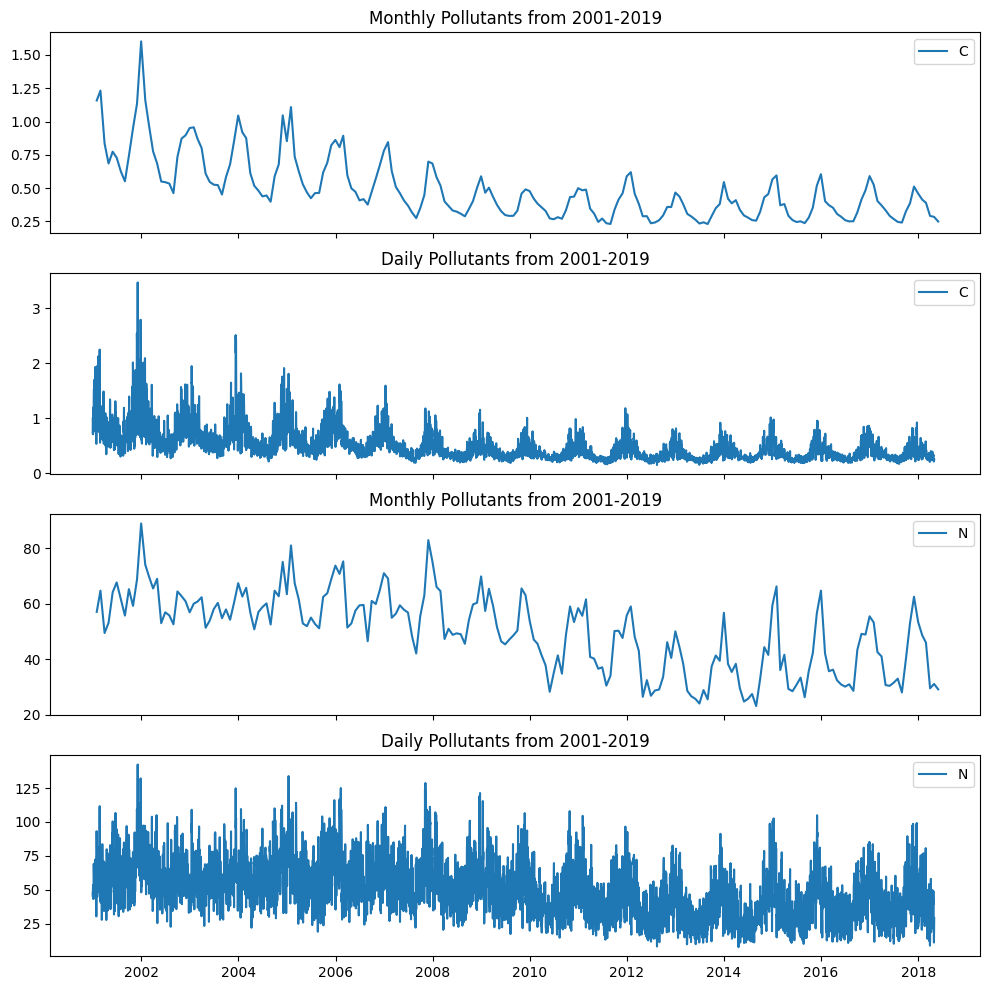

In [ ]:
monthly_df = df.resample('M').mean()
daily_df = df.resample('D').mean()

fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Gráfico mensual
axs[0].plot(monthly_df['CO'])
axs[0].set_title('Monthly Pollutants from 2001-2019')
axs[0].legend('CO')

# Gráfico diario
axs[1].plot(daily_df['CO'])
axs[1].set_title('Daily Pollutants from 2001-2019')
axs[1].legend('CO')

# Gráfico mensual
axs[2].plot(monthly_df['NO_2'])
axs[2].set_title('Monthly Pollutants from 2001-2019')
axs[2].legend('NO_2')

# Gráfico diario
axs[3].plot(daily_df['NO_2'])
axs[3].set_title('Daily Pollutants from 2001-2019')
axs[3].legend('NO_2')

# Mostrar el gráfico
plt.show()

### Descomposiciones en tendencia



In [ ]:
# Importar las bibliotecas necesarias
from statsmodels.tsa.stattools import adfuller, kpss

# Función para realizar la prueba Dickey-Fuller aumentada (ADF)
def adf_test(timeseries):
    # Imprimir información sobre la prueba
    print('Resultados de la Prueba Dickey-Fuller:')
    print('Hipótesis Nula: Raíz Unitaria Presente')
    print('Estadístico de Prueba < Valor Crítico => Rechazar Hipótesis Nula')
    print('Valor p =< Alfa(0.05) => Rechazar Hipótesis Nula\n')

    # Realizar la prueba ADF y obtener los resultados
    dftest = adfuller(timeseries, autolag='AIC')

    # Crear una Serie de pandas para mostrar los resultados de manera organizada
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de Prueba', 'Valor p', '#Lags Usados', 'Número de Observaciones Usadas'])

    # Agregar los valores críticos al DataFrame
    for key, value in dftest[4].items():
        dfoutput[f'Valor Crítico {key}'] = value

    # Imprimir los resultados
    print (dfoutput, '\n')

# Función para realizar la prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
def kpss_test(timeseries, regression='c'):
    # Imprimir información sobre la prueba
    print('Resultados de la Prueba KPSS:')
    print('Hipótesis Nula: Datos Estacionarios/Estacionarios con Tendencia')
    print('Estadístico de Prueba > Valor Crítico => Rechazar Hipótesis Nula')
    print('Valor p =< Alfa(0.05) => Rechazar Hipótesis Nula\n')

    # Realizar la prueba KPSS y obtener los resultados
    kpsstest = kpss(timeseries, regression=regression)

    # Crear una Serie de pandas para mostrar los resultados de manera organizada
    kpss_output = pd.Series(kpsstest[0:3], index=['Estadístico de Prueba', 'Valor p', 'Lags Usados'])

    # Agregar los valores críticos al DataFrame
    for key, value in kpsstest[3].items():
        kpss_output[f'Valor Crítico {key}'] = value

    # Imprimir los resultados
    print (kpss_output, '\n')


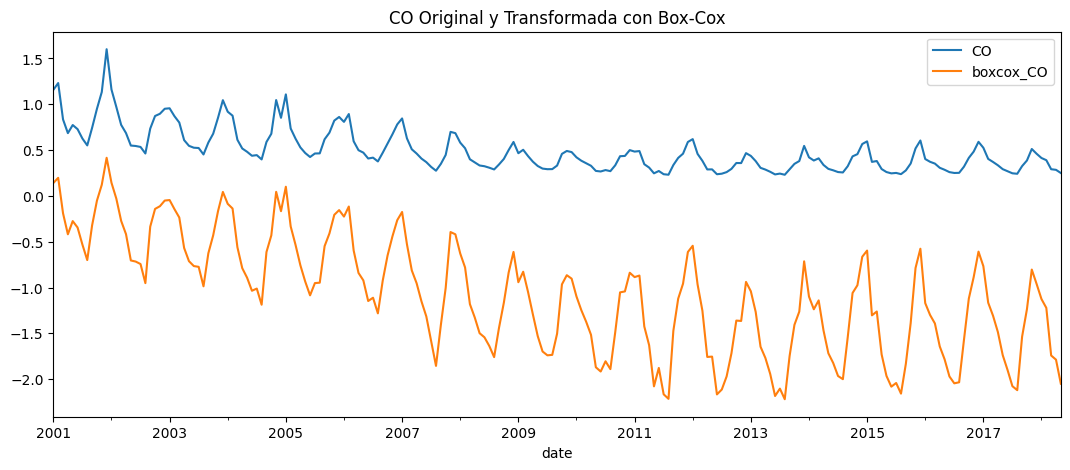

In [ ]:
from scipy.stats import boxcox

# Crear un DataFrame para la columna 'CO' de monthly_df
sta_co_df = pd.DataFrame(monthly_df['CO'])

# Aplicar la transformación de Box-Cox a la columna 'CO'
sta_co_df['boxcox_CO'], co_lamda = boxcox(sta_co_df['CO'])

# Graficar las series temporales original y transformada con Box-Cox
sta_co_df.plot(figsize=(13, 5), title='CO Original y Transformada con Box-Cox')
plt.show()


In [ ]:
print('Box-Cox Lambda Value: ', co_lamda)

Box-Cox Lambda Value:  -0.5318180444784282


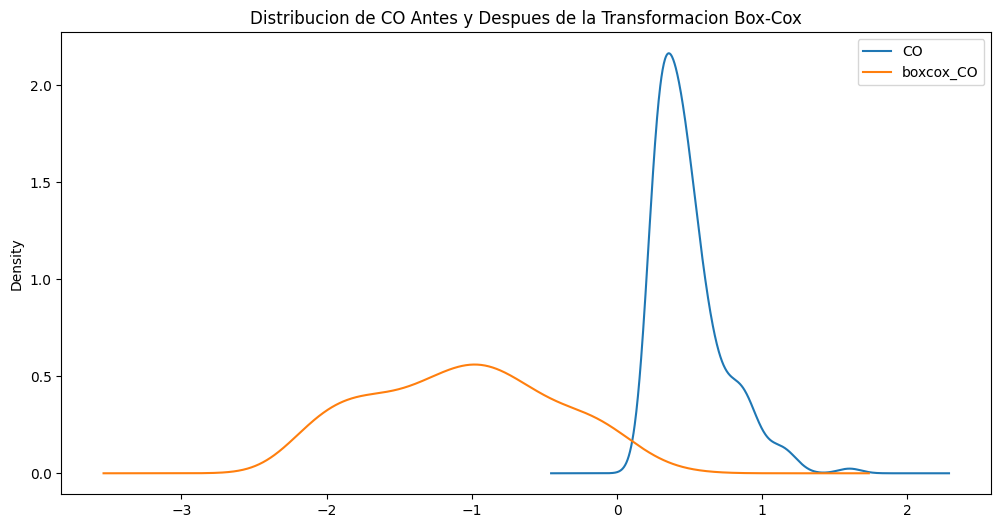

In [ ]:
# Crea un gráfico de densidad de kernel (KDE) para la distribución original y transformada de CO
sta_co_df.plot.kde(figsize=(12, 6), title='Distribucion de CO Antes y Despues de la Transformacion Box-Cox')
plt.show()

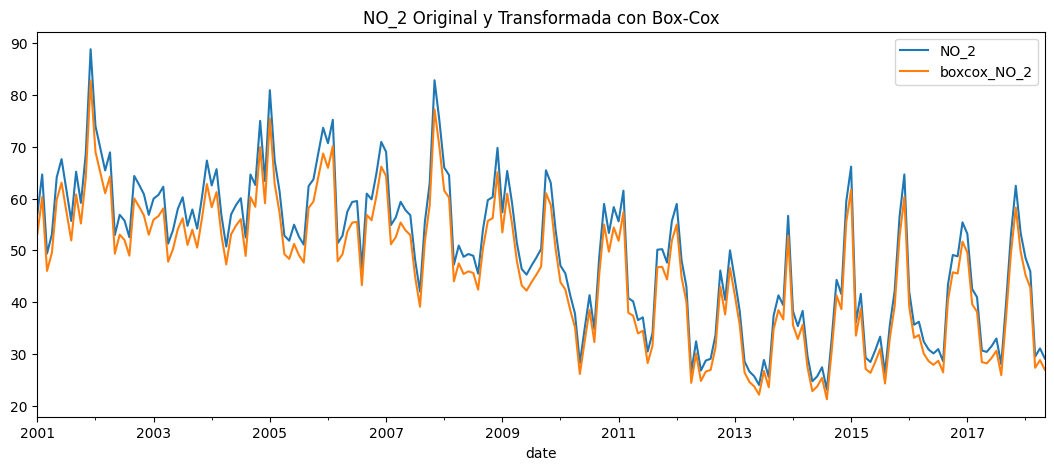

In [ ]:
# Visualización de la serie temporal de NO_2 antes y después de la transformación de Box-Cox

# Crea un DataFrame para la columna PM10 de la serie temporal mensual
sta_no2_df = pd.DataFrame(monthly_df.NO_2)

# Aplica la transformación de Box-Cox a la columna PM10
sta_no2_df['boxcox_NO_2'], no2_lamda = boxcox(sta_no2_df.NO_2)

# Crea un gráfico de la serie temporal original y transformada de PM10
sta_no2_df.plot(figsize=(13, 5), title='NO_2 Original y Transformada con Box-Cox')
plt.show()

In [ ]:
print('Box-Cox Lambda Value: ', no2_lamda)

Box-Cox Lambda Value:  0.9832397575356921


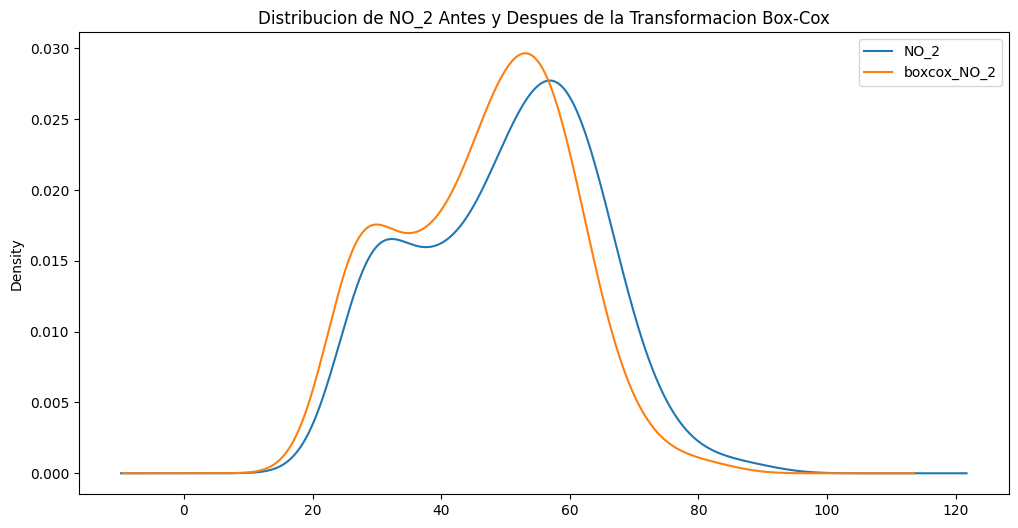

In [ ]:
# Crea un gráfico de densidad de kernel (KDE) para la distribución original y transformada de CO
sta_no2_df.plot.kde(figsize=(12, 6), title='Distribucion de NO_2 Antes y Despues de la Transformacion Box-Cox')
plt.show()

Las descomposiciones en tendencia se caracterizan por focalizar su análisis en la dirección general y a largo plazo de los datos. Observando las emisiones de gases `CO` y `NO2` en Madrid, en ambos casos es posible advertir una tendencia general negativa de emision gases la cual es más evidente en el caso del NO2 entre los años 2010 a 2013 aproximadamente.

###Descomposición de la Estacionalidad (extraído del notebook de clase "Suavizado exponencial para prediccion madrid")

Una estaciòn es un período de tiempo fijo que contiene la repetición completa del patrón de su serie temporal. Preste mucha atención, sus datos pueden repetirse todos los días, pero si los fines de semana se ven diferentes a los días de la semana, entonces su temporada es una semana, no un día.

Podemos pensar en nuestra serie temporal como compuesta por una combinación de `nivel`, `tendencia`, `estacionalidad` y `ruido`.

- `NIVEL`: el valor promedio de la serie
- `TENDENCIA`: el valor creciente o decreciente en la serie
- `ESTACIONALIDAD`: el ciclo de corto plazo que se repite en la serie
- `RUIDO`: la variación aleatoria en la serie, denominada residual por la función de descomposición_estacional

La descomposición de la estacionalidad es una herramienta de análisis que nos proporciona un marco para pensar en los diferentes componentes de nuestra serie temporal. Podemos descomponer nuestra serie para entender la influencia de cada componente y utilizar esa información para orientar nuestra preparación de datos, selección de modelos y ajuste de modelos. Como vimos en la sección de suavizado exponencial, los modelos que tienen en cuenta la estacionalidad, en comparación con aquellos que no la tienen, tienen un efecto destacado en nuestra capacidad para prever la serie.

La descomposición estacional en `statsmodels` solo requiere que indiquemos si el modelo es aditivo o multiplicativo.

Esta es una descomposición ingenua, utilizada principalmente para la descripción de datos.

El **modelo aditivo** es Y[t] = T[t] + S[t] + e[t]

El **modelo multiplicativo** es Y[t] = T[t] * S[t] * e[t]

Los resultados se obtienen estimando primero la tendencia aplicando un filtro de convolución a los datos. Luego, la tendencia se elimina de la serie y el promedio de esta serie sin tendencia para cada período es el componente estacional devuelto.


## Additive vs. Multiplicative

En una serie de tiempo multiplicativa, los componentes descompuestos se multiplican para formar la serie de tiempo. En una serie multiplicativa hay tendencia creciente, aumenta la amplitud de la actividad estacional y todo se vuelve más exagerado. La tendencia multiplicativa se parece más a una curva exponencial y la estacionalidad multiplicativa tiene ondas que crecen en amplitud a lo largo del tiempo.

En un modelo aditivo asumimos que los componentes de la serie de tiempo tienen un efecto aditivo, que la amplitud del efecto estacional es aproximadamente la misma, que el tamaño de los residuos es mayormente constante.

Los datos del mundo real no siempre serán puramente aditivos o multiplicativos, puede haber secciones de cualquier tipo. Es importante probar varios parámetros y ver cuál se ajusta mejor a nuestros datos.

In [ ]:
def plot_seasonal_decomposition(dataframe, column_name):
    # Creación de un DataFrame para la columna especificada de la serie temporal mensual
    decomposition_df = pd.DataFrame(dataframe[column_name])

    # Aplicación de la descomposición estacional aditiva
    seasonal_adit = seasonal_decompose(decomposition_df, model='additive')

    # Aplicación de la descomposición estacional multiplicativa
    seasonal_mult = seasonal_decompose(decomposition_df, model='multiplicative')

    # Creación de dos figuras para visualizar la descomposición estacional aditiva y multiplicativa
    fig_1 = seasonal_adit.plot()
    fig_2 = seasonal_mult.plot()

    # Configuración de títulos y dimensiones de las figuras
    fig_1.suptitle(f'Descomposición Estacional Aditiva - {column_name}', fontsize=25)
    fig_1.set_figheight(10)
    fig_1.set_figwidth(20)

    fig_2.suptitle(f'Descomposición Estacional Multiplicativa - {column_name}', fontsize=25)
    fig_2.set_figheight(10)
    fig_2.set_figwidth(20)

    # Mostrar las figuras
    plt.tight_layout()
    plt.show()

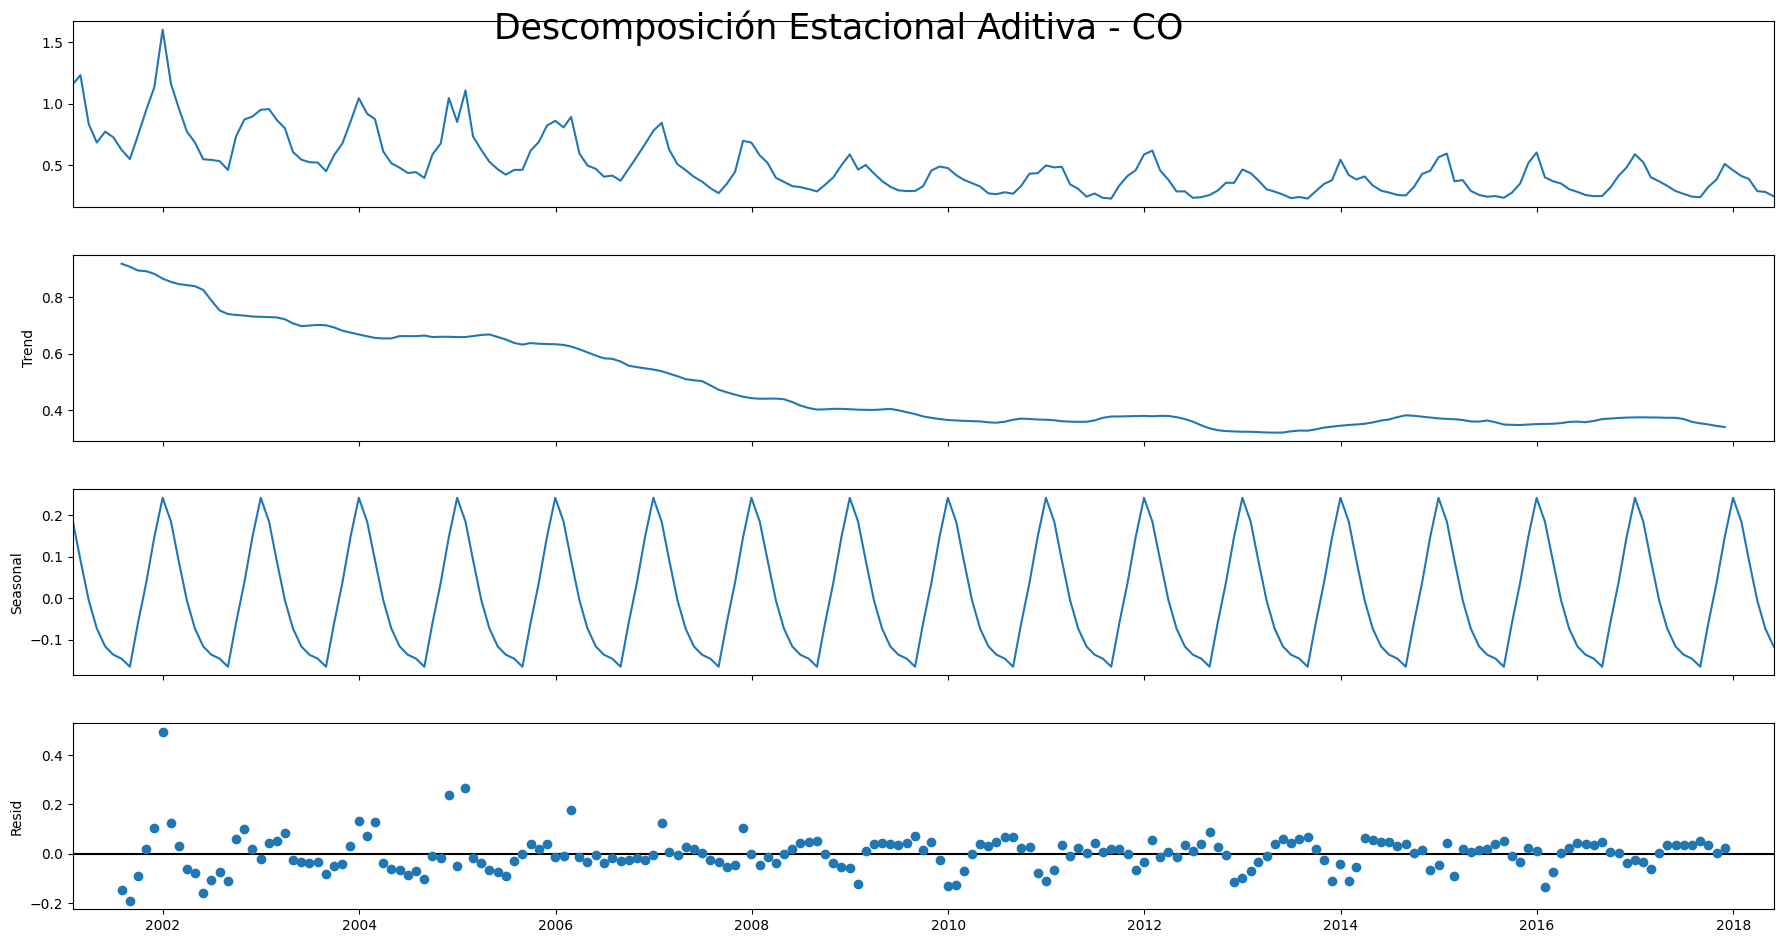

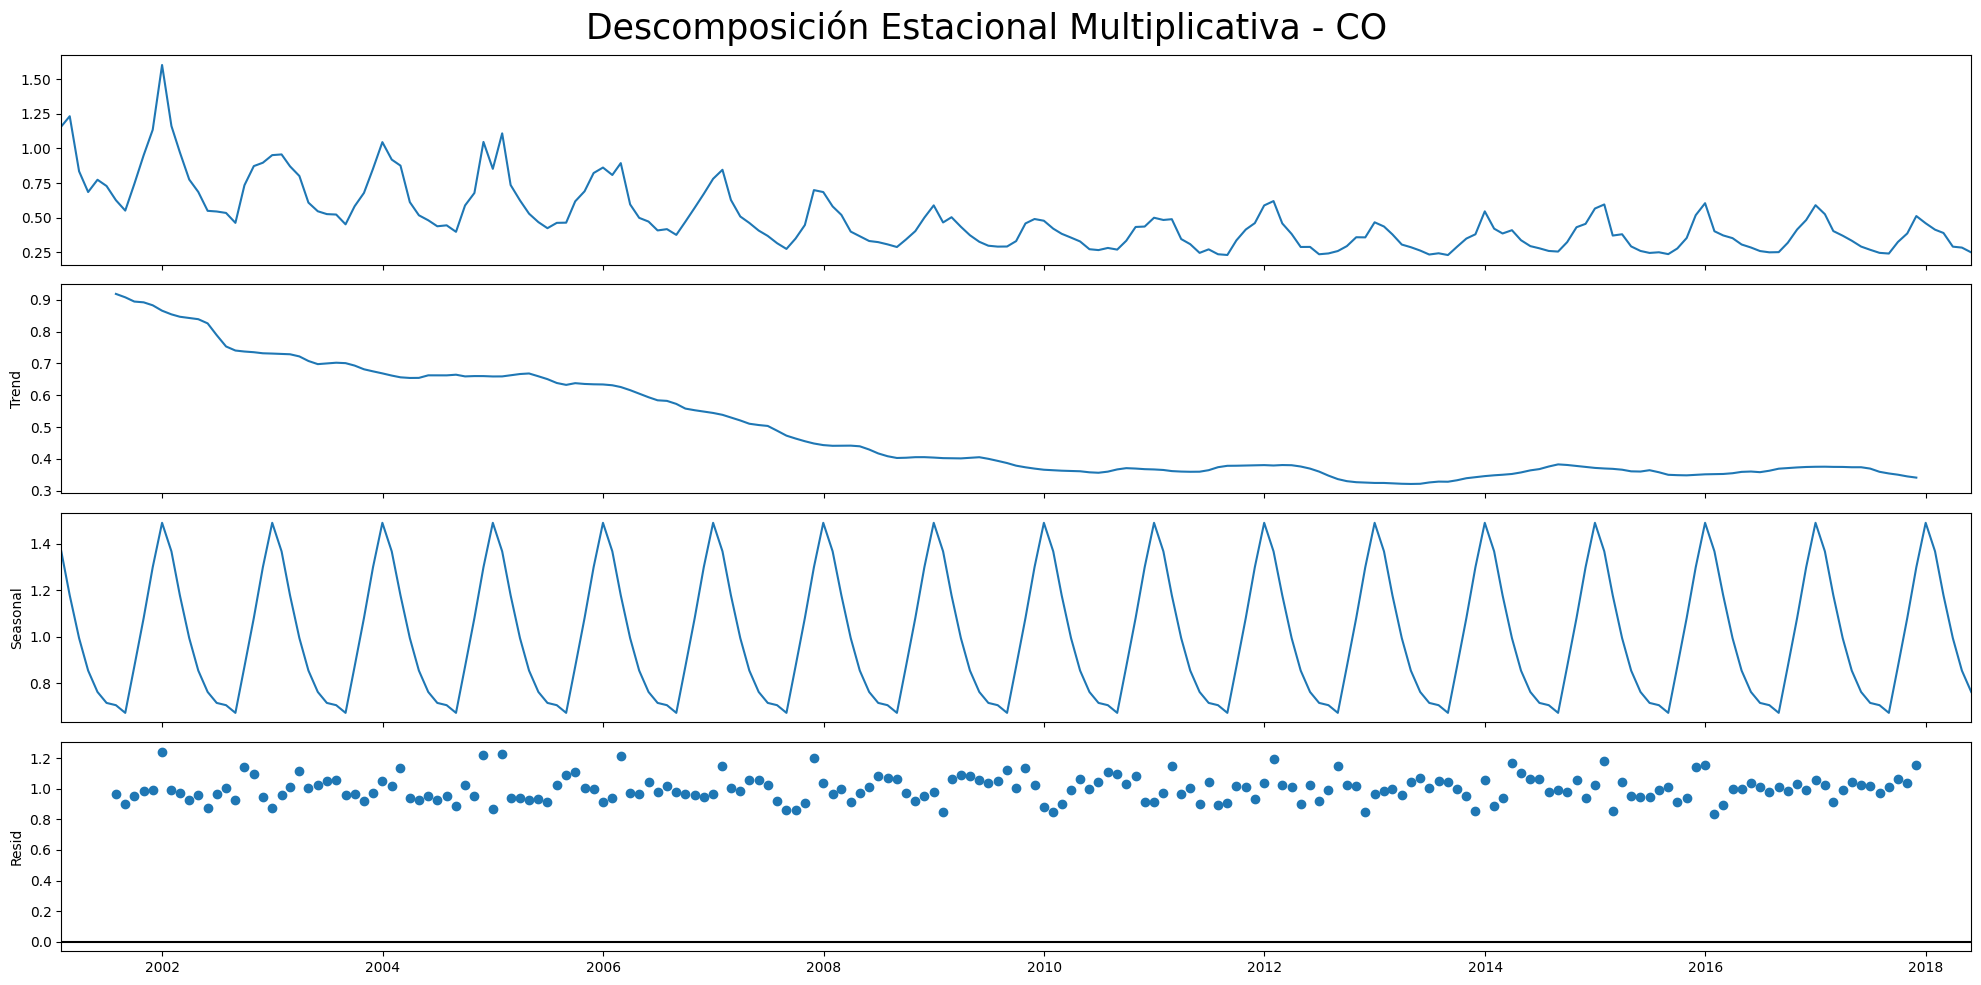

In [ ]:
# Llama a la función con tu DataFrame y nombre de columna de interés
plot_seasonal_decomposition(monthly_df, 'CO')

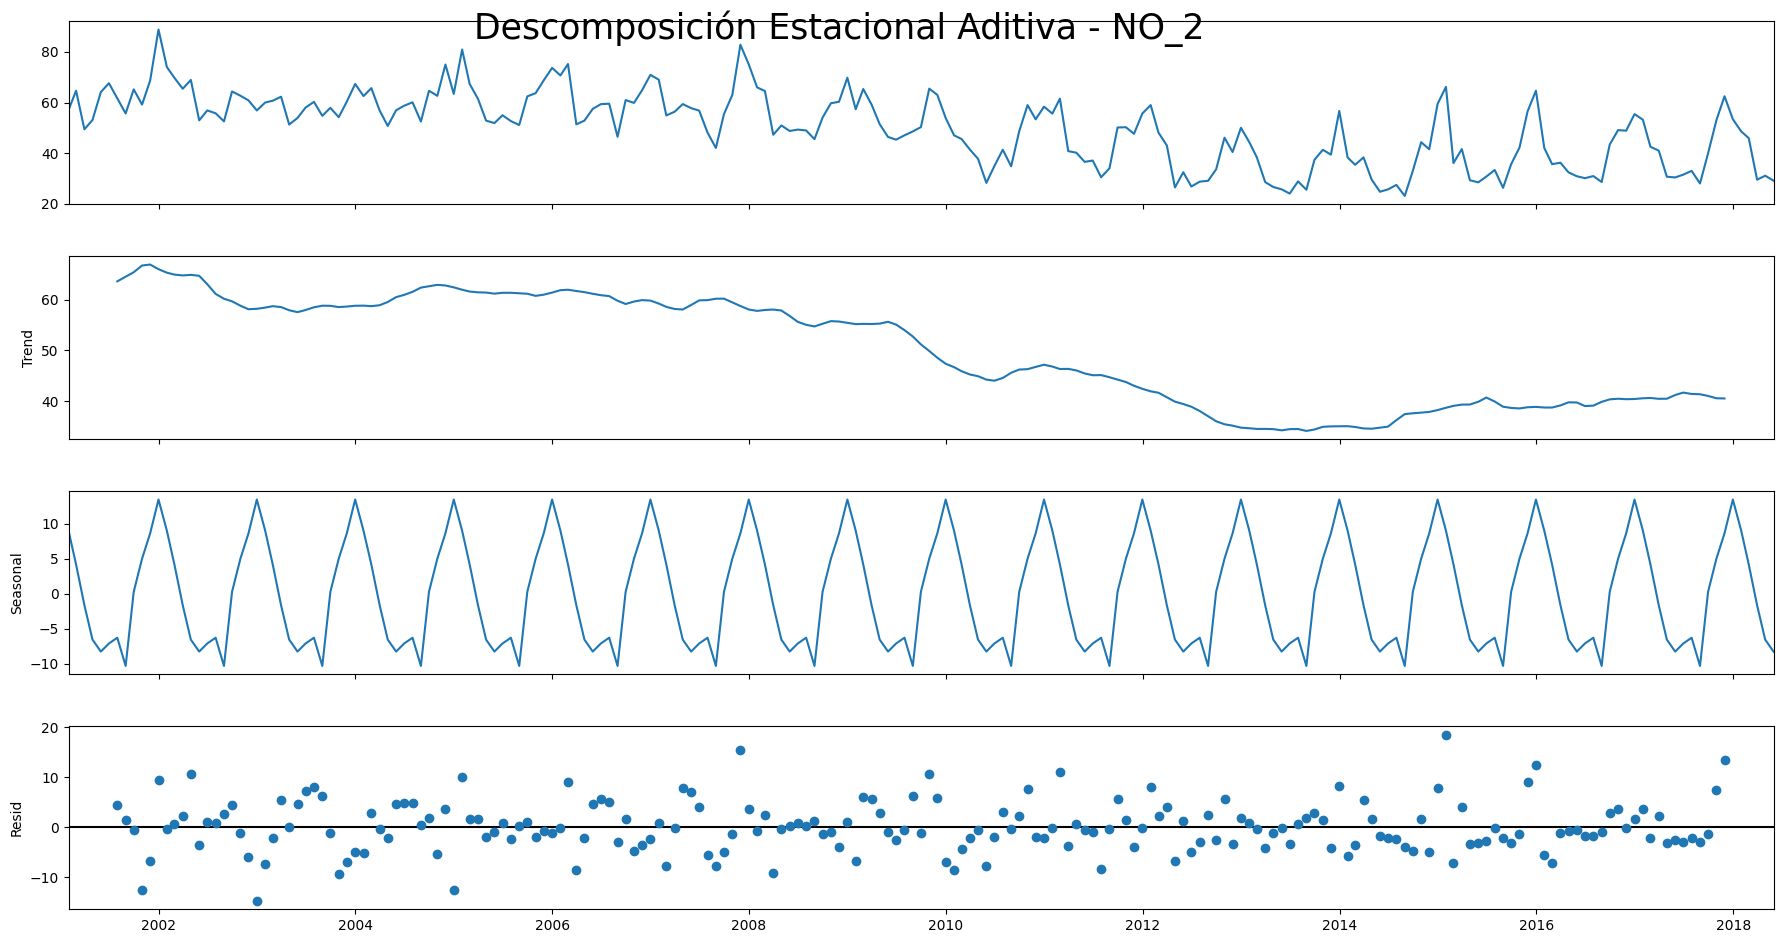

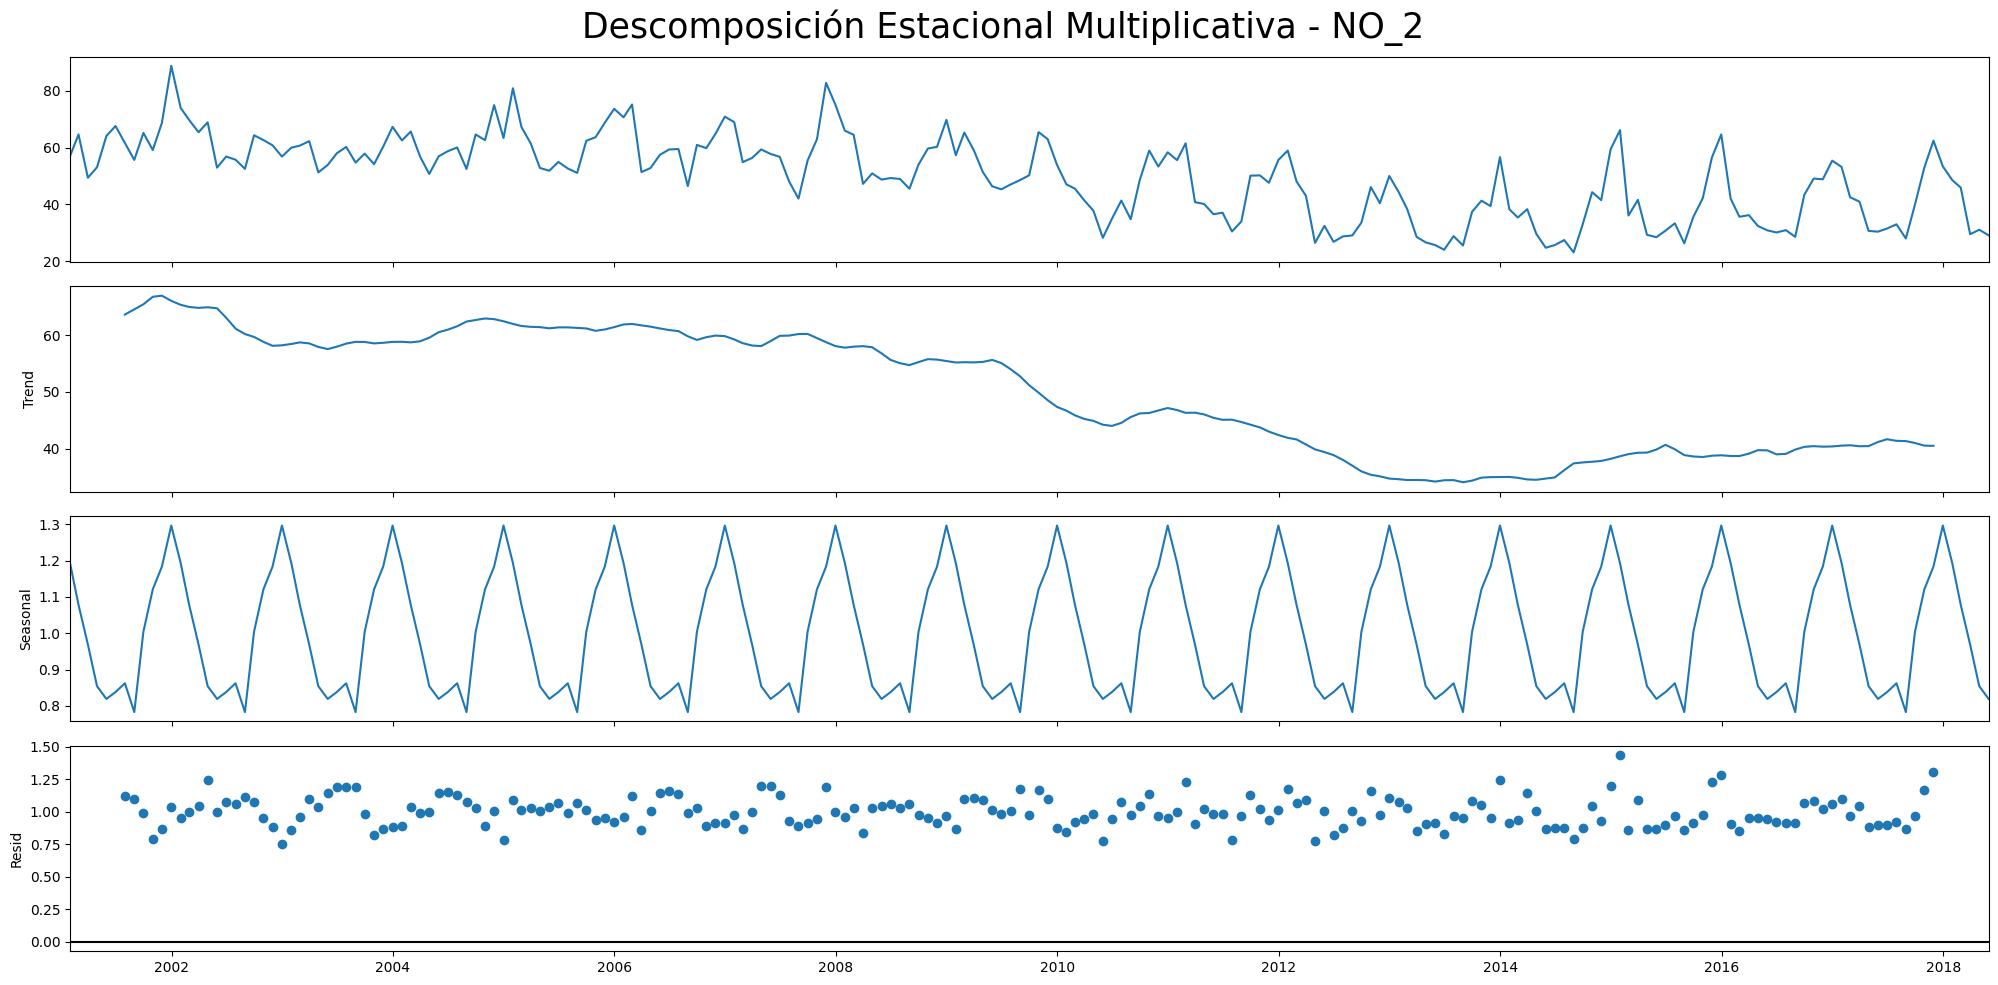

In [ ]:
# Llama a la función con tu DataFrame y nombre de columna de interés
plot_seasonal_decomposition(monthly_df, 'NO_2')

Los graficos de tendencia de emisiones de ambos gases coinciden con las conclusiones anteriormente expuestas.
Al comparar las descomposiciones estacionales vs. multiplicativas para cada gas, no es posible reconocer diferencias marcadas ya que la tendencia, estacionalidad y los residuos presentan el mismo comportamiento en ambos casos.

## Problema 3:

- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter  para los gases de madrid 'NO_2' y 'CO'.

- Encontrar los parámetros generando un set de validación y MSE.

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST .

- Plotear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para estas series.


In [ ]:
monthly_df

BEN        CO       EBE       MXY      NMHC       NO_2  \
date                                                                      
2001-01-31  4.288614  1.157704  3.933503  6.615309  0.238853  57.026588   
2001-02-28  4.388892  1.231877  4.188518  7.678057  0.255657  64.654926   
2001-03-31  3.112439  0.834881  2.963135  5.986781  0.174614  49.401208   
2001-04-30  2.564130  0.685284  2.733724  4.834906  0.122473  53.098803   
2001-05-31  2.710334  0.773770  3.024398  5.474336  0.155161  64.109276   
...              ...       ...       ...       ...       ...        ...   
2018-01-31  0.730815  0.413898  0.405121       NaN  0.062502  48.570821   
2018-02-28  0.664053  0.390074  0.321575       NaN  0.083594  45.923543   
2018-03-31  0.436196  0.291500  0.214616       NaN  0.057328  29.501152   
2018-04-30  0.408435  0.284760  0.270076       NaN  0.058704  31.076017   
2018-05-31  0.383333  0.250000  0.200000       NaN  0.060000  29.125000   

                   NOx       OXY        O_3       PM10       PXY       SO_2  \
date                                                                          
2001-01-31  149.162291  3.021721  19.518731  29.482594  2.567149  24.975948   
2001-02-28  172.395372  3.408621  20.537844  37.317374  3.112746  29.098308   
2001-03-31  105.734135  2.699047  29.003657  25.028387  2.292239  18.523222   
2001-04-30   95.828954  2.137110  40.265716  25.732844  1.891479  15.162090   
2001-05-31  110.500603  2.453922  41.040143  28.862101  2.123550  14.722957   
...                ...       ...        ...        ...       ...        ...   
2018-01-31  107.392614       NaN  25.434958  15.146917       NaN   6.377244   
2018-02-28   82.247751       NaN  35.539549  13.749411       NaN   6.207986   
2018-03-31   43.268005       NaN  58.979532   8.058836       NaN   4.441962   
2018-04-30   44.348882       NaN  59.106670  17.293412       NaN   4.578086   
2018-05-31   33.750000       NaN  56.357143   4.461538       NaN   4.500000   

                 TCH        TOL       station      PM25         NO       CH4  
date                                                                          
2001-01-31  1.541657  16.017533  2.807902e+07       NaN        NaN       NaN  
2001-02-28  1.541261  16.343071  2.807902e+07       NaN        NaN       NaN  
2001-03-31  1.436774  11.113731  2.807902e+07       NaN        NaN       NaN  
2001-04-30  1.347268   9.155111  2.807902e+07       NaN        NaN       NaN  
2001-05-31  1.390607  11.532559  2.807902e+07       NaN        NaN       NaN  
...              ...        ...           ...       ...        ...       ...  
2018-01-31  1.361405   2.613253  2.807904e+07  9.625445  38.364219  1.299588  
2018-02-28  1.378636   1.880506  2.807904e+07  8.839066  23.688117  1.295647  
2018-03-31  1.320502   0.976725  2.807904e+07  4.678132   8.977035  1.263973  
2018-04-30  1.343488   1.276255  2.807904e+07  7.702037   8.653960  1.285359  
2018-05-31  1.323333   0.850000  2.807904e+07  2.666667   2.875000  1.263333  

[209 rows x 18 columns]

In [ ]:
train_len = int(len(monthly_df.CO) * 0.7) + 3
val_test_len = int(len(monthly_df.CO) * 0.15) - 1

# Dividir el conjunto de datos
train_data = monthly_df.iloc[:train_len]
val_data = monthly_df.iloc[train_len:train_len + val_test_len]
test_data = monthly_df.iloc[train_len + val_test_len:]

In [ ]:
# Visualización de los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de validación: {len(val_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Tamaño del conjunto de entrenamiento: 149
Tamaño del conjunto de validación: 30
Tamaño del conjunto de prueba: 30


In [ ]:
def des_optimizer(train, valid, colum, alphas, betas):

    best_alpha = None
    best_beta = None
    best_mae = float("inf")

    for alpha in alphas:
        for beta in betas:
            # Ajustar el modelo Double Exponential Smoothing con el conjunto de entrenamiento
            des_model = ExponentialSmoothing(train[colum],
                                             trend="add"
                                             ).fit(smoothing_level=alpha,
                                                   smoothing_slope=beta)

            # Predecir 'step' puntos hacia adelante en el conjunto de validación
            y_pred_valid = des_model.forecast(len(valid[colum]))

            # Calcular el error absoluto medio (MAE) con respecto al conjunto de validación
            mae_valid = mean_absolute_error(valid[colum], y_pred_valid)

            # Actualizar las mejores configuraciones si se encuentra un menor MAE en el conjunto de validación
            if mae_valid < best_mae:
                best_alpha = alpha
                best_beta = beta
                best_mae = mae_valid

    # Imprimir las mejores configuraciones encontradas
    print("best_alpha:", round(best_alpha, 2),
          "best_beta:", round(best_beta, 2),
          "best_mae_valid:", round(best_mae, 4))

    return best_alpha, best_beta, best_mae

In [ ]:
def plot_prediction(y_pred, col, label):
    plt.figure(figsize=(12,6), dpi=100)
    train_data[col].plot(legend=True, label="TRAIN")
    val_data[col].plot(legend=True, label="VALID")
    test_data[col].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

In [ ]:
# Definir los rangos de alpha y beta a considerar
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

# Llamar a la función para encontrar las mejores configuraciones utilizando el conjunto de validación
best_alpha, best_beta, best_mae_valid = des_optimizer(train_data, val_data, 'CO', alphas, betas)

# Ajustar el modelo Double Exponential Smoothing con las mejores configuraciones utilizando todo el conjunto de entrenamiento
final_des_model = ExponentialSmoothing(pd.concat([train_data['CO'], val_data['CO']], axis=0),
                                       trend="add"
                                       ).fit(smoothing_level=best_alpha,
                                             smoothing_slope=best_beta,
                                             )

# Predecir puntos hacia adelante
y_co_pred = final_des_model.forecast(val_test_len)

best_alpha: 0.11 best_beta: 0.61 best_mae_valid: 0.0842


In [ ]:
# Imprimir el MAE en el conjunto de prueba
mae_co_test_1 = mean_absolute_error(test_data['CO'], y_co_pred)
print("MAE on Test Set:", round(mae_co_test_1, 4))

MAE on Test Set: 0.2191


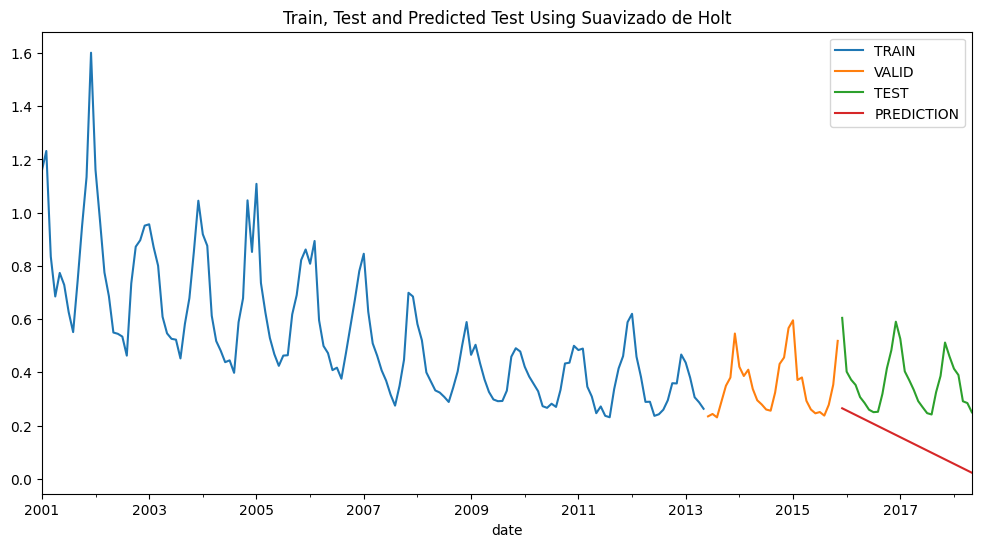

In [ ]:
plot_prediction(y_co_pred, 'CO', "Suavizado de Holt")

In [ ]:
# Llamar a la función para encontrar las mejores configuraciones utilizando el conjunto de validación
best_alpha_no2, best_beta_no2, best_mae_valid_no2 = des_optimizer(train_data, val_data, 'NO_2', alphas, betas)

# Ajustar el modelo Double Exponential Smoothing con las mejores configuraciones utilizando todo el conjunto de entrenamiento
final_des_model = ExponentialSmoothing(pd.concat([train_data['NO_2'], val_data['NO_2']], axis=0),
                                       trend="add"
                                       ).fit(smoothing_level=best_alpha_no2,
                                             smoothing_slope=best_beta_no2,
                                             )

# Predecir 24 puntos hacia adelante
y_no2_pred = final_des_model.forecast(val_test_len)

best_alpha: 0.11 best_beta: 0.61 best_mae_valid: 8.3953


In [ ]:
# Imprimir el MAE en el conjunto de prueba
mae_no2_test = mean_absolute_error(test_data['NO_2'], y_no2_pred)
print("MAE on Test Set:", round(mae_no2_test, 4))

MAE on Test Set: 9.7515


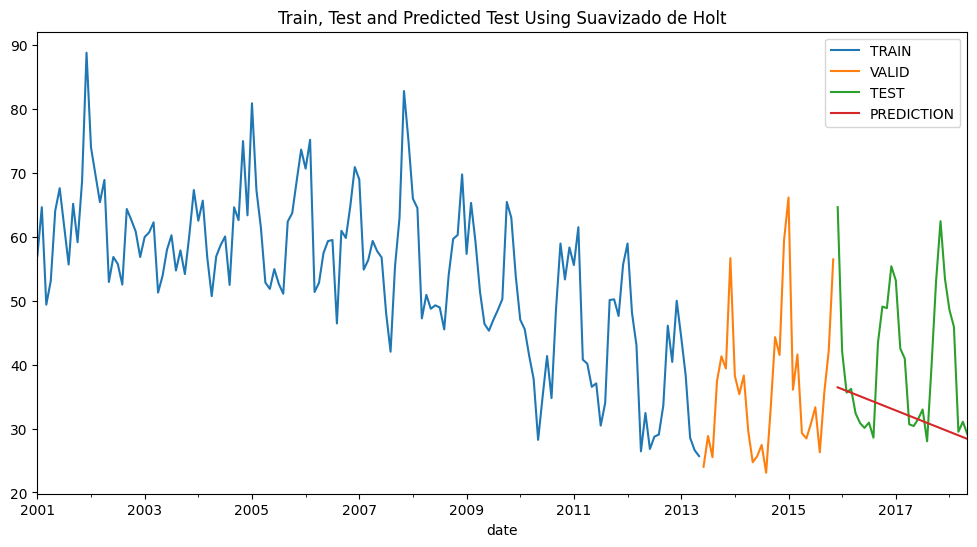

In [ ]:
plot_prediction(y_no2_pred, 'NO_2', "Suavizado de Holt")

In [ ]:
# Triple Exponential Smoothing (Holt-Winters)

def tes_optimizer(train, valid, colum, abg):

    best_alpha = None
    best_beta = None
    best_gamma = None
    best_mae = float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train[colum],
                                         trend="add",
                                         seasonal="add",
                                         seasonal_periods=12
                                         ).fit(smoothing_level=comb[0],
                                               smoothing_slope=comb[1],
                                               smoothing_seasonal=comb[2])

        y_pred_valid = tes_model.forecast(len(valid[colum]))

        mae_valid = mean_absolute_error(valid[colum], y_pred_valid)

        if mae_valid < best_mae:
            best_alpha = comb[0]
            best_beta = comb[1]
            best_gamma = comb[2]
            best_mae = mae_valid

    print("best_alpha:", round(best_alpha, 2),
          "best_beta:", round(best_beta, 2),
          "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_data, val_data, 'CO', abg)

tes_model = ExponentialSmoothing(pd.concat([train_data['CO'], val_data['CO']], axis=0),
                                 trend="add",
                                 seasonal="add",seasonal_periods=12
                                 ).fit(smoothing_level=best_alpha,
                                       smoothing_slope=best_beta,
                                       smoothing_seasonal=best_gamma)

y_co_pred_2 = tes_model.forecast(val_test_len)

best_alpha: 0.3 best_beta: 0.1 best_gamma: 0.7 best_mae: 0.0375


In [ ]:
# Imprimir el MAE en el conjunto de prueba
mae_co_test_2 = mean_absolute_error(test_data['CO'], y_co_pred_2)
print("MAE on Test Set:", round(mae_co_test_2, 4))

MAE on Test Set: 0.0499


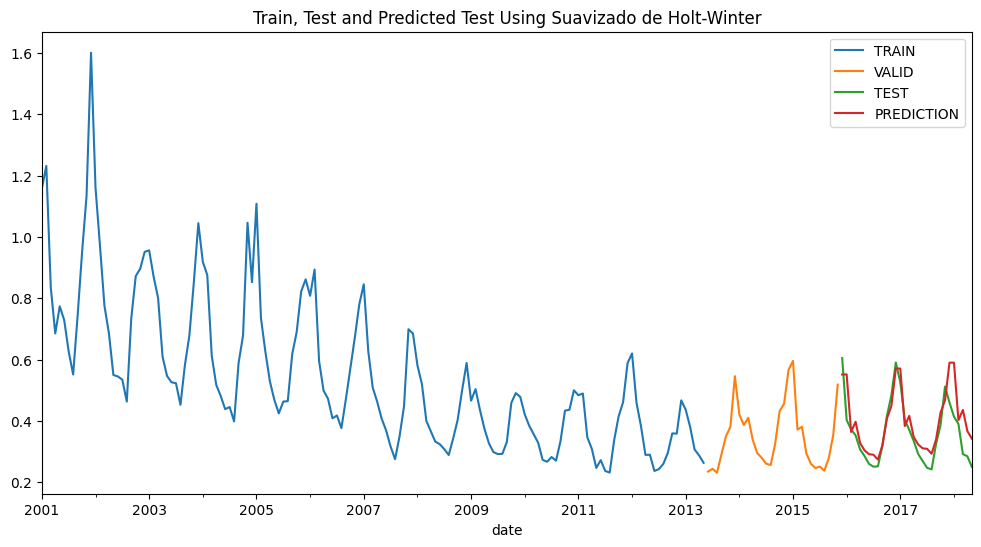

In [ ]:
plot_prediction(y_co_pred_2, 'CO', "Suavizado de Holt-Winter")

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_data, val_data, 'NO_2', abg)

tes_model = ExponentialSmoothing(pd.concat([train_data['NO_2'], val_data['NO_2']], axis=0),
                                 trend="add",
                                 seasonal="add",seasonal_periods=12
                                 ).fit(smoothing_level=best_alpha,
                                       smoothing_slope=best_beta,
                                       smoothing_seasonal=best_gamma)

y_no2_pred_2 = tes_model.forecast(val_test_len)

best_alpha: 0.1 best_beta: 0.7 best_gamma: 0.1 best_mae: 4.4277


In [ ]:
# Imprimir el MAE en el conjunto de prueba
mae_no2_test_2 = mean_absolute_error(test_data['NO_2'], y_no2_pred_2)
print("MAE on Test Set:", round(mae_no2_test_2, 4))

MAE on Test Set: 9.0251


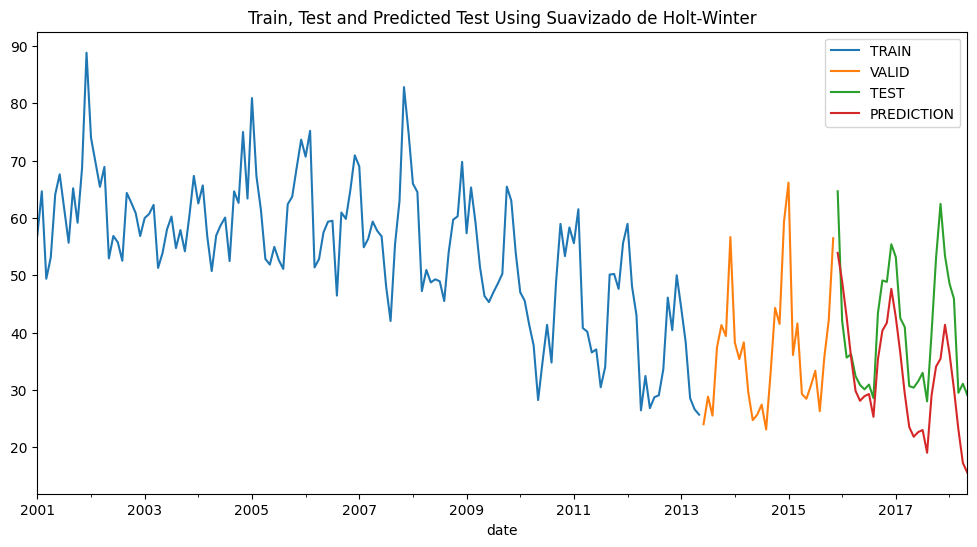

In [ ]:
plot_prediction(y_no2_pred_2, 'NO_2', "Suavizado de Holt-Winter")

En general, las predicciones de emision de gases de CO y NO2 utilizando el Suavizado Exponencial Doble o de Holt, no coincide con la del conjunto de datos, dando como resultado un comportamiento totalmente diferente. Sin embargo, al aplicar el Suavizado Triple o de Holt-Winters, las predicciones se ajustan bastante bien a los mismos.